
正态分布——听起来非常耳熟，用起来也很顺手——因为很多语言都已经内置了有关正态分布的各种工具。但其实，在这个最普遍、最广泛的正态分布背后，要生成它还有很多学问呢。

$$f(x \; | \; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi} } \; e^{ -\frac{(x-\mu)^2}{2\sigma^2} }$$

c:\python35\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


(-4, 4, 0, 0.5)

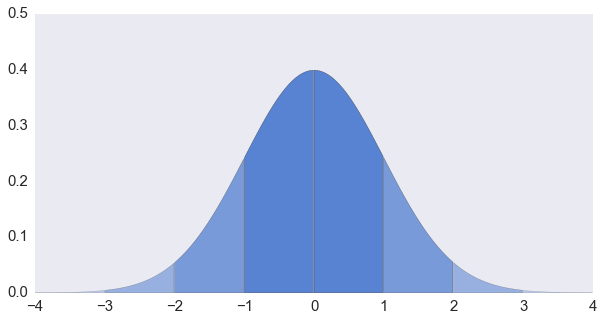

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
sigma = 1
mu = 0
sns.set(style="dark", palette="muted", color_codes=True, font_scale=1.5)
x = [np.arange(i - 4, i - 3, 0.01) for i in range(8)]
f = [1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x[i] - mu)**2 / (2 * sigma**2) ) for i in range(8)]
alpha = [0.3,0.5,0.7,0.9,0.9,0.7,0.5,0.3]
plt.figure(figsize=(10,5))
for i in range(8):
    plt.fill_between(x[i], 0, f[i], alpha= alpha[i])
plt.axis((-4, 4, 0, 0.5))

难道教科书上没有讲吗？看看概率书上是怎么说的……比如我手头这本浙大版的《概率论与数理统计》（第四版）第 378 页上说……“标准正态变量的分布函数 $\Phi(x)$ 的反函数不存在显式，故不能用逆变换法产生标准正态变量……”

## 反变换法

等下！反函数不存在显式……这都什么年代了，没有解析解难道不能用数值解嘛！求百分位这么常见的动作，怎么会不能做呢？Excel 里面提供了`NORMINV` 函数，R 语言里面有 `qnorm`，在 Python 里面可以用 SciPy.stats 里提供的 `norm.ppf`：

Wall time: 1.83 s


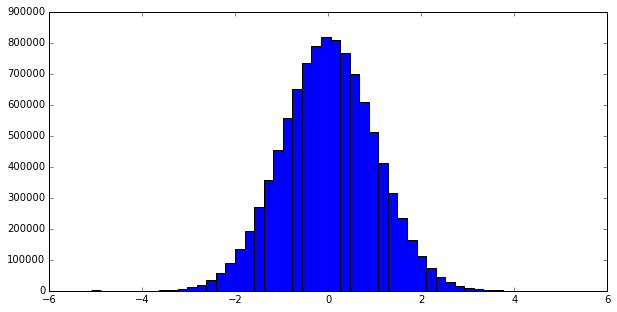

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
N = 10 ** 7
%matplotlib inline
%time x = stats.norm.ppf(np.random.rand(N, 1))
plt.figure(figsize=(10,5))
plt.hist(x,50)
plt.show()

当然……不算快啦，但还是可以凑合用的。这个给高斯积分求逆的实现可以看 [SciPy 的 ndtri() 函数](https://github.com/scipy/scipy/blob/master/scipy/special/cephes/ndtri.c)。这段代码来自于 Cephes 数学库，采用了分段近似的方法但是精度还相当不错——明明是 80 年代末就有了！

这个变换当然很直观啦，如果你再想变回均匀分布，只要再用一次分布函数就好了：

(array([ 199880.,  200053.,  200089.,  199305.,  200060.,  199665.,
         199376.,  200245.,  200102.,  200145.,  200014.,  200621.,
         199956.,  199825.,  199769.,  200563.,  199884.,  199341.,
         200075.,  199740.,  200102.,  199101.,  199915.,  200572.,
         199155.,  200229.,  200029.,  199620.,  200332.,  200060.,
         200066.,  200161.,  200295.,  200538.,  200811.,  199789.,
         200488.,  200006.,  200385.,  199852.,  199923.,  199313.,
         200398.,  200158.,  200690.,  199612.,  200713.,  199847.,
         200004.,  199128.]),
 array([  1.51489850e-07,   2.00001472e-02,   4.00001429e-02,
          6.00001385e-02,   8.00001342e-02,   1.00000130e-01,
          1.20000126e-01,   1.40000121e-01,   1.60000117e-01,
          1.80000113e-01,   2.00000108e-01,   2.20000104e-01,
          2.40000100e-01,   2.60000095e-01,   2.80000091e-01,
          3.00000087e-01,   3.20000082e-01,   3.40000078e-01,
          3.60000074e-01,   3.80000070e-01,   4.000000

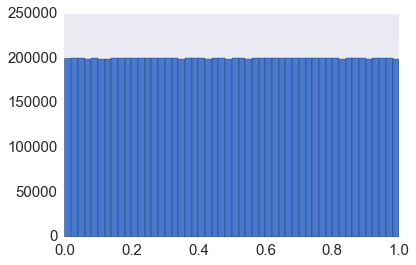

In [111]:
x = stats.norm.cdf(x)
plt.hist(x, 50)

## 中心极限定理……还是不要用的好

那教科书上教的是什么方法呢？它祭出了中心极限定理…… 取 $n$ 个相互独立的均匀分布 $X_i = U(0,1)$，$E(X_i)=\frac{1}{2}$，$\mathrm{Var}(X_i)=\frac{1}{12}$，那么根据中心极限定理，$n$ 比较大的时候近似有

$$Z = \frac{\displaystyle\sum_{i=1}^n X_i - E\left(\displaystyle\sum_{i=1}^n X_i\right)}{\sqrt{\mathrm{Var}\left(\displaystyle\sum_{i=1}^n X_i\right)}}= \frac{\displaystyle\sum_{i=1}^n X_i - \frac{n}{2}}{\sqrt{n} \sqrt{\frac{1}{12}}} \sim N(0,1).$$

取 $n=12$ 则近似有

$$Z = \sum_{i=1}^{12} U_i - 6 \sim N(0,1).$$

这个呢……我们也来试试看

Wall time: 2.55 s


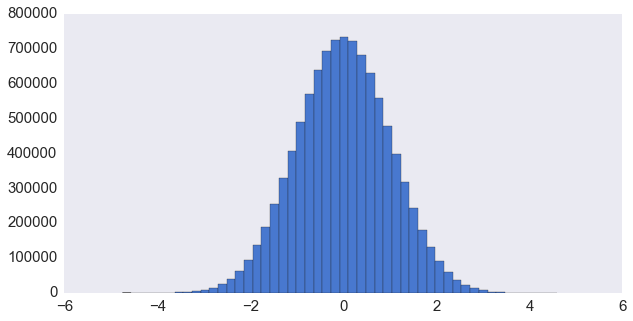

In [110]:
%time g = np.sum(np.random.rand(N, 12), 1) - 6
plt.figure(figsize=(10,5))
plt.hist(g,50)
plt.show()

更慢了。形状倒是有那么点意思。那我们来看看它生成的质量如何：

In [73]:
import scipy.stats as stats
stats.normaltest(g)

NormaltestResult(statistic=4785.7373110266581, pvalue=0.0)

竟然可耻地毫无争议地失败了…… (╯‵□′)╯︵┻━┻ 我们的样本数比较大（$10^7$），用仅仅 12 个做平均是很难得到合理的“正态”样本的。可要是取更大的 $n$ 的话，要生成太多的随机数又实在太慢了。如果需要的样本数少一点（比如 1000 个）倒还可以勉强凑合：

In [85]:
stats.normaltest(np.sum(np.random.rand(1000, 12), 1) - 6)

NormaltestResult(statistic=1.8167274769305835, pvalue=0.40318339808171011)

好吧，这方法大概只有理论上的意义。我们来看一个比较常用的方法是怎么做的：

## Box-Muller 变换

我们再来看看这个反变换的事。基本上我们的问题就是要计算

$$I = \int_{-\infty}^{\infty} e^{-\frac{x^2}{2}} \mathrm{d} x$$

大家都知道这个积分没有初等函数的表示。不过呢

$$I^2 = \int_{-\infty}^{\infty} e^{-\frac{x^2}{2}} \mathrm{d} x \int_{-\infty}^{\infty} e^{-\frac{y^2}{2}} \mathrm{d} y = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} e^{-\frac{x^2+y^2}{2}} \mathrm{d} x \, \mathrm{d} y$$

注意看右边，这个形式让我们想到了……极坐标！令 $x = r\cos\theta$，$y = r\sin\theta$，那么 $\mathrm{d}x\,\mathrm{d}y$ 变成 $\mathrm{d}r\,\mathrm{d}\theta$ 的时候要记得乘上雅各比矩阵：

$$\mathrm{d}x\,\mathrm{d}y = \begin{vmatrix}\frac{\partial x}{\partial r} & \frac{\partial x}{\partial \theta} \\ \frac{\partial y}{\partial r} & \frac{\partial y}{\partial \theta} \end{vmatrix} \mathrm{d}r\,\mathrm{d}\theta= r\, \mathrm{d}r\,\mathrm{d}\theta$$

于是

$$I ^2 = \int_{r=0}^{\infty}\int_{\theta=0}^{2\pi}e^{-\frac{r^2}{2}} r\,\mathrm{d}r\,\mathrm{d}\theta = 2\pi\int_{r=0}^{\infty}e^{-\frac{r^2}{2}} r\,\mathrm{d}r = 2\pi\int_{r=0}^{\infty}e^{-\frac{r^2}{2}} \mathrm{d}\left(\frac{r^2}{2}\right) =2\pi$$ 

有了这个技巧就求出了积分。如果再把反变换方法应用到这里，$\Theta$ 可以均匀地取 $[0,2\pi]$ 中的值，即

$$\Theta = 2\pi U_1$$
还可以同理计算出

$$\mathbb{P}(R\leq r) = \int_{r'=0}^r e^{-\frac{r'^2}{2}}\,r'\,\mathrm{d}r' = 1- e^{-r^2/2}$$

令其满足均匀分布 $1-U_2$，则

$$R = \sqrt{-2\ln(U_2)}$$

因此，只需要产生均匀分布 $U_1$ 和 $U_2$，就可以计算 $R$ 和 $\Theta$，进而计算出 $X$ 和 $Y$ 两个相互独立的正态分布了。

Python 里面的 `random.gauss()` 函数用的就是这样一个实现，但是用它实在太慢了，我们还是靠 NumPy 吧：

Wall time: 736 ms


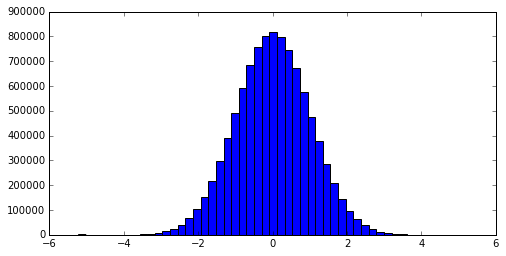

In [33]:
import random
#%time x = [random.gauss(0, 1) for _ in range(N)]
%time x = np.sqrt(-2 * np.log(np.random.rand(N, 1))) * np.cos(2 * np.pi * np.random.rand(N, 1))
plt.figure(figsize=(8, 4))
plt.hist(x, 50)
plt.show()

当然……不是很快。不但是因为 Python 本身的速度，更是因为要计算好多次三角函数。NumPy 里面的 `numpy.random.randn()` 则又做了进一步的优化。代码可以见[这里](https://github.com/numpy/numpy/blob/master/numpy/random/mtrand/randomkit.c)的 `rk_gauss()` 函数。它的原理是这样的：我们要的分布是

$$
\begin{align}
X &= R \cos(\Theta) =\sqrt{-2 \ln U_1} \cos(2 \pi U_2)\\
Y &= R \sin(\Theta) =\sqrt{-2 \ln U_1} \sin(2 \pi U_2)
\end{align}$$

如果我们产生两个独立的均匀分布 $U_1$ 和 $U_2$，并且**抛弃单位圆之外的点**，那么 $s = U_1^2 + U_2^2$ 也是均匀分布的。为什么呢？因为 

$$f_{U_1,U_2}(u,v) = \frac{1}{\pi}$$

将坐标代换为 $r$ 和 $\theta$，乘上一个雅各比行列式，我们前面算过了这个行列式就等于 $r$，所以：

$$f_{R,\Theta}(r, \theta) = \frac{r}{\pi}$$

$\Theta$ 是均匀分布在 $[0, 2\pi)$ 上的，所以

$$f_R(r) = \int_0^{2\pi} f_{R,\Theta}(r, \theta)\,\mathrm{d}\theta = 2r$$

再做一次变量代换
 
$$f_{R^2}(s) = f_R(r) \frac{\mathrm{d}r}{\mathrm{d}(r^2)} = 2r \cdot \frac{1}{2r} = 1$$

好了，既然 $s$ 也是均匀分布的，那么 $\sqrt{-2 \ln U_1}$ 和 $\sqrt{-2 \ln s}$ 就是同分布的。而又因为

$$\cos \Theta, \sin\Theta = \frac{U_1}{R}, \frac{U_2}{R} = \frac{U_1}{\sqrt{s}}, \frac{U_2}{\sqrt{s}}$$

那么

$$u\sqrt{\frac{-2\ln s}{s}}, v\sqrt{\frac{-2\ln s}{s}}$$

就是我们要找的两个独立正态分布。

Wall time: 363 ms


(array([  2.00000000e+00,   5.00000000e+00,   1.70000000e+01,
          3.10000000e+01,   1.08000000e+02,   2.06000000e+02,
          4.81000000e+02,   9.44000000e+02,   2.10900000e+03,
          4.10600000e+03,   8.06400000e+03,   1.47290000e+04,
          2.58830000e+04,   4.40610000e+04,   7.11500000e+04,
          1.09951000e+05,   1.64259000e+05,   2.33487000e+05,
          3.17215000e+05,   4.13636000e+05,   5.17845000e+05,
          6.19933000e+05,   7.12056000e+05,   7.80792000e+05,
          8.21631000e+05,   8.26373000e+05,   7.98764000e+05,
          7.35165000e+05,   6.52880000e+05,   5.52168000e+05,
          4.48857000e+05,   3.49191000e+05,   2.59102000e+05,
          1.85405000e+05,   1.26262000e+05,   8.23000000e+04,
          5.17050000e+04,   3.14150000e+04,   1.76950000e+04,
          9.96900000e+03,   5.16900000e+03,   2.65100000e+03,
          1.19500000e+03,   6.01000000e+02,   2.63000000e+02,
          9.30000000e+01,   5.40000000e+01,   1.40000000e+01,
        

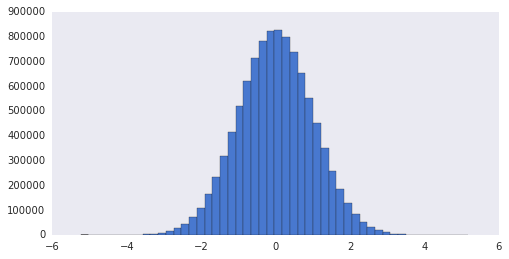

In [104]:
%time x = np.random.randn(N)
plt.figure(figsize=(8,4))
plt.hist(x,50)

这速度还是十分不错的（当然一大原因是 NumPy 是 C 实现的）。本来 Box-Muller 包括 Matlab 在内的各大数值软件所采用的标准正态分布生成方法，直到出现了速度更快的金字塔 (Ziggurat) 方法。NumPy 出于兼容性的考虑迟迟没有更新，导致生成随机数的速度已经落在了 Matlab 和 [Julia](https://github.com/JuliaLang/julia/blob/master/test/perf/kernel/ziggurat.jl) 后面。那么这个神奇的金字塔又是怎么回事呢？我们另开一篇细谈。